### Siapakaan Model 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_6000.csv')
df.head(10)

,content,sentimen
0,politikus senior pdi perjuangan panda nababan ...,Negative
1,wali kota depok mohammad idris menanggapi nyin...,Negative
2,ketua tim pemenangan nasional tpn ganjar prano...,Negative
3,aksi arogan sopir fortuner mengacungkan pedang...,Negative
4,7 bocah korban gigitan seekor monyet liar depo...,Negative
5,menteri koordinator bidang pembangunan manusia...,Negative
6,ketua tim hukum nasional amin ari yusuf menyes...,Negative
7,macet jalan tb simatupang arah pasar rebo jaka...,Negative
8,pekerja terjatuh plafon masjid at muttaqien ka...,Negative
9,eks direktur rsud padang sidimpuan sumatera ut...,Negative


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

#### World Cloud

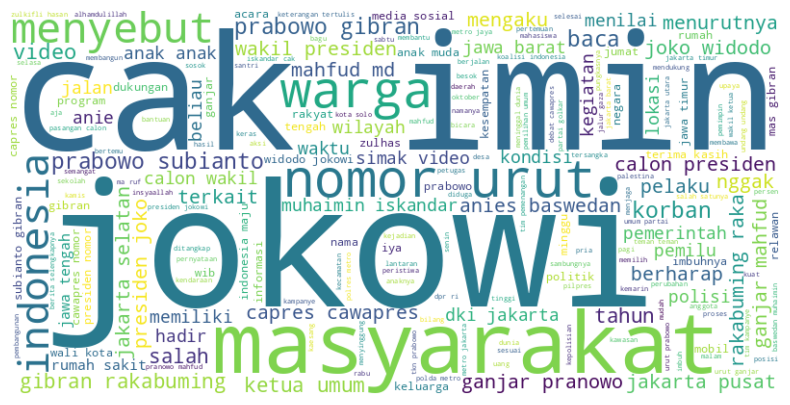

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all texts into one string
all_texts = ' '.join(df['content'])

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_texts)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### LSA

LSA Topics:

Topic #0:
prabowo gibran ganjar jokowi anies presiden indonesia cawapres mahfud debat

Topic #1:
israel korban gaza hamas palestina pelaku serangan warga rumah tewas

Topic #2:
imin cak cak imin anies ganjar amin mahfud muhaimin baswedan anies baswedan

Topic #3:
israel gaza hamas palestina serangan imin cak imin cak jalur gaza anies

Topic #4:
ganjar mahfud ganjar mahfud jokowi pranowo ganjar pranowo mahfud md md pdip presiden

Topic #5:
jokowi pan zulhas partai indonesia presiden pemilu anies joko widodo widodo

Topic #6:
kpk firli bahuri firli bahuri syahrul syl pemerasan metro jaya ketua kpk polda metro

Topic #7:
pan zulhas debat gibran cawapres zulkifli hasan zulkifli hasan debat cawapres firli

Topic #8:
debat jokowi debat cawapres cawapres tni jakarta ikn ekonomi dki heru

Topic #9:
debat korban jokowi pelaku prabowo kpu capres pan cawapres debat cawapres


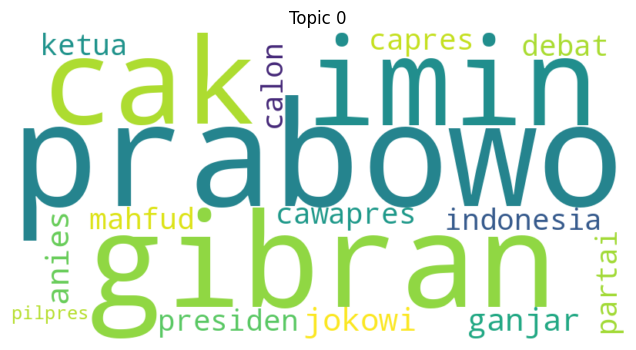

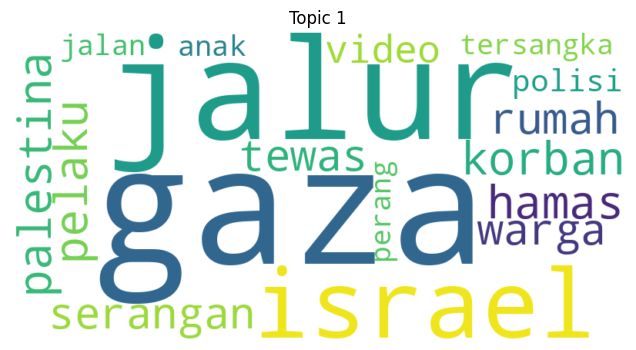

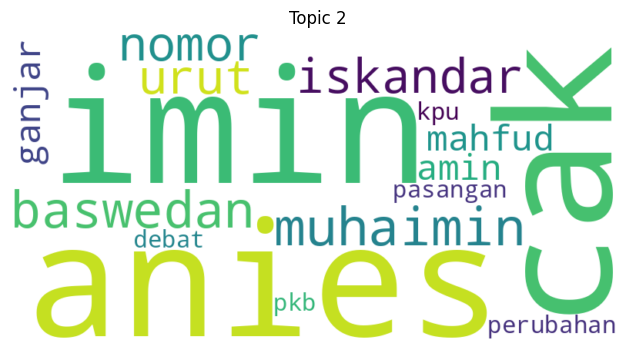

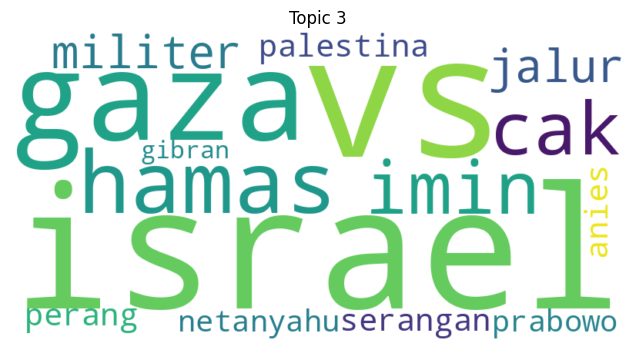

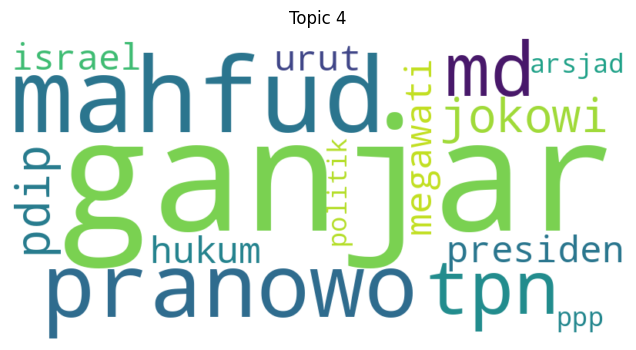

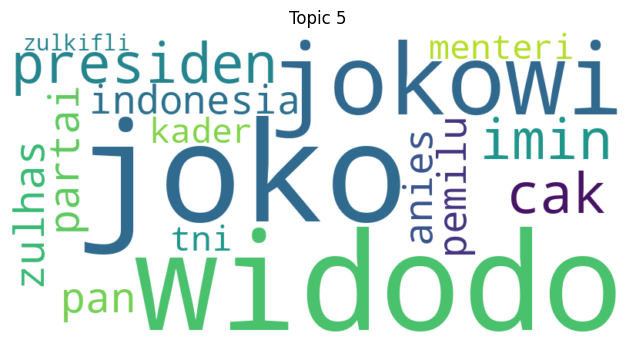

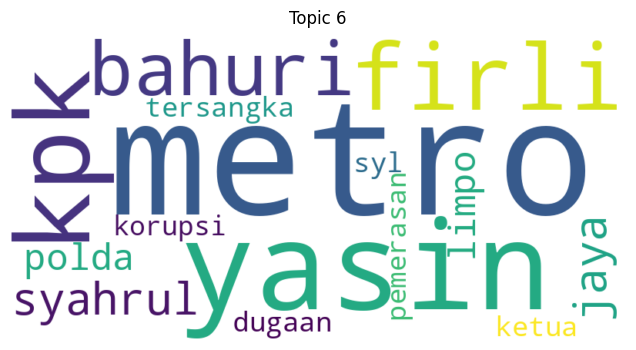

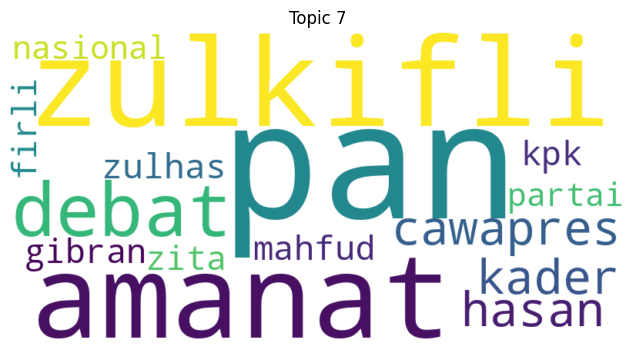

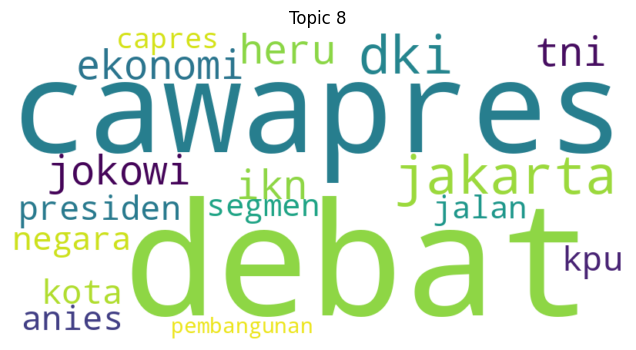

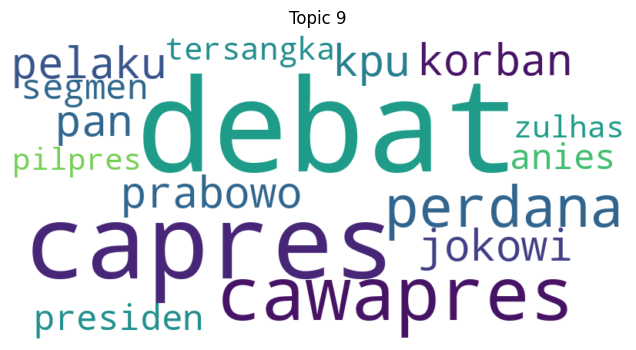

In [10]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Define the number of topics
num_topics = 10

# Perform LSA
lsa_model = TruncatedSVD(n_components=num_topics, random_state=42)
lsa_train_features = lsa_model.fit_transform(tfidf_train_features)

# Get feature names from the TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Function to print the most important words for each topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

# Print the most important words for each topic
print("LSA Topics:")
print_top_words(lsa_model, feature_names, 10)

# Generate a word cloud for each topic
for i in range(num_topics):
    # Get the most important words for the topic
    top_words = [feature_names[j] for j in lsa_model.components_[i].argsort()[:-20 - 1:-1]]
    # Join them into a single string
    topic_text = ' '.join(top_words)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_text)
    # Display the generated image
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Topic ' + str(i))
    plt.axis('off')
    plt.show()


### Naiye Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [12]:
# Train Naive Bayes classifier
nb_classifier =  MultinomialNB(alpha= 0.1,fit_prior=False)
nb_classifier.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = nb_classifier.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred) * 100
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted') * 100
print("F1 Score:", f1)

Accuracy: 73.66666666666667
F1 Score: 73.24275661448925


#### Model SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# Initialize SVM model
svm_model = SVC(C=100, gamma=0.1, kernel='sigmoid', random_state=42)

# Fit the model
svm_model.fit(tfidf_train_features, y_train_encoded)

# Predict on test data
y_pred = svm_model.predict(tfidf_test_features)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
print("F1 Score:", f1)

Accuracy: 0.7783333333333333
F1 Score: 0.7766190159096201
